# Analysis code for "*MW accelerometry via MSP Timing: Spin Periods*" 
Authors: Aakash Ravi and Reza Ebadi

## Import libraries and define plot settings

In [1]:
from psrqpy import QueryATNF
import pandas as pd
import numpy as np
from numpy import random
from scipy.special import erf
from scipy.stats import norm, rayleigh
import scipy.linalg as linalg
import emcee
import corner
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib import rc, rcParams
from IPython.display import display, Math
import astropy.coordinates as coord
coord.galactocentric_frame_defaults.set('pre-v4.0') 

# PLOT SETTINGS
%matplotlib inline
%config InlineBackend.figure_format = "retina"
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16
rcParams["xtick.direction"] = "in"
rcParams["ytick.direction"] = "in"

## Query the ATNF Catalogue

In [2]:
query = QueryATNF()
df = query.pandas
cols = df[['NAME',
           'P0',
           'P0_ERR',
           'P1',
           'P1_ERR',
           'P1_I',
           'XX',
           'YY',
           'ZZ',
           'DIST',
           'DIST_DM',
           'DIST_A',
           'DIST_A_ERR',
           'DIST_AMN',
           'DIST_AMX',
           'GL',
           'GB',
           'PMTOT',
           'PMTOT_ERR',
           'RAJD',
           'RAJ_ERR',
           'DECJD',
           'DECJ_ERR',
           'PX',
           'PX_ERR',
           'PB',
           'PB_ERR',
           'PBDOT',
           'PBDOT_ERR',
           'VTRANS',
           'ECC',
           'OMDOT',
           'GAMMA',
           'MINMASS']];

## Filter the data

In [3]:
filt = cols['P0']<0.01
data = cols[filt]
print(str(data.shape[0]) + ' pulsars in the catalogue have period < 10 ms.')

filt = filt & cols['DIST'].notna()
data = cols[filt]
print('Among them, ' + str(data.shape[0]) + ' pulsars have DIST given.')

filt = filt & cols['P1'].notna()
data = cols[filt]
print('Among them, ' + str(data.shape[0]) + ' pulsars have P1 measured.')

filt = filt & cols['PMTOT'].notna()
data = cols[filt]
print('Among them, ' + str(data.shape[0]) + ' pulsars have PMTOT given.')

filt = filt & cols['PMTOT_ERR'].notna()
data = cols[filt]
print('Among them, ' + str(data.shape[0]) + ' pulsars have PMTOT_ERR given.')

filt = filt & cols['NAME'].str.strip().str[-1].str.isdigit()
data = cols[filt]
print('Among them, ' + str(data.shape[0]) + ' pulsars are not in clusters.');

333 pulsars in the catalogue have period < 10 ms.
Among them, 332 pulsars have DIST given.
Among them, 229 pulsars have P1 measured.
Among them, 144 pulsars have PMTOT given.
Among them, 143 pulsars have PMTOT_ERR given.
Among them, 117 pulsars are not in clusters.


## Categorize pulsars and compute distance errors

In [4]:
# ASSOCIATION DISTANCES
is_DA = data['DIST']==data['DIST_A']
data_DA = data[is_DA]
print(str(data_DA.shape[0]) + ' pulsars in the sample have association distances.')
data_DA['DIST_AMX'] - data_DA['DIST_A']
data_DA.insert(0,'errplus', data_DA['DIST_AMX'] - data_DA['DIST_A'])
data_DA.insert(0,'errmnus', data_DA['DIST_A'] - data_DA['DIST_AMN'])
data_DA.insert(0,'errmax', data_DA[['errplus','errmnus']].max(axis=1))
data_DA.insert(0,'DA_err', data_DA['DIST_A_ERR'].combine_first(data_DA['errmax']))

# DISPERSION MEASURE-DERIVED DISTANCES
is_DDM = data['DIST']==data['DIST_DM']
data_DDM = data[is_DDM]
print(str(data_DDM.shape[0]) + ' pulsars in the sample have dispersion measure distances.')
data_DDM.insert(0,'DDM_err',0.4 * data_DDM['DIST'])

# PARALLAX-DERIVED DISTANCES
data_PX=data[~is_DA & ~is_DDM]
print(str(data_PX.shape[0]) + ' pulsars in the sample have parallax distances.')
data_PX.insert(0,'DPX_err',data_PX['PX_ERR']/(data_PX['PX']**2))

data_Derr = pd.concat([data_DDM, data_DA, data_PX])
data_Derr.insert(0,'D_errADM', data_Derr['DA_err'].combine_first(data_Derr['DDM_err']))
data_Derr.insert(0,'D_err', data_Derr['D_errADM'].combine_first(data_Derr['DPX_err']))
data_Derr['D_err'] = data_Derr['DA_err'].combine_first(0.4*data_Derr['DIST_DM'])
# if there is any case with DA given but no error can be assigned

data_Derr = data_Derr.drop_duplicates(subset='NAME', keep='first')
Pdata = data_Derr;

18 pulsars in the sample have association distances.
72 pulsars in the sample have dispersion measure distances.
28 pulsars in the sample have parallax distances.


## Calculate  $f\left(D,l,b\right)$ and $a$  for all pulsars in sample
\begin{align}
f\left(D,l,b\right) & = -\cos b\left[\text{cos}l+\frac{D/r_{0}\cdot\cos b-\cos l}{\sin^{2}l+\left(D/r_{0}\cdot\cos b-\cos l\right)^{2}}\right], \\
a & = c\dot{P}/P-\mu^2 D
\end{align}

In [5]:
# DEFINE CONSTANTS
c = 299792458
maspyr = np.pi/2.0435328e16
kpc = 9.69394202136e19/np.pi
R0 = 8.3*kpc

Pdata.insert(0,'a',c * Pdata['P1']/Pdata['P0'] - (Pdata['PMTOT']*maspyr)**2*(Pdata['DIST']*kpc))
Pdata.insert(0,'zkpc', Pdata['ZZ'])
Pdata.insert(0,'aperp', -3.27e-11*(1.25*Pdata['zkpc']/(np.sqrt(Pdata['zkpc']**2+0.0324)+0.58*Pdata['zkpc'])))
Pdata.insert(0,'beta',(Pdata['DIST']*kpc/R0)*np.cos(Pdata['GB']/180*np.pi)-np.cos(Pdata['GL']/180*np.pi))
Pdata.insert(0,'x', -np.cos(Pdata['GB']/180*np.pi)*(np.cos(Pdata['GL']/180*np.pi)
            +Pdata['beta']/((np.sin(Pdata['GL']/180*np.pi))**2+Pdata['beta']**2)))
Pdata.insert(0,'aplan', 1.89e-10*Pdata['x'])
Pdata.insert(0,'abr', Pdata['a'] - 0*Pdata['aperp']*np.sin(Pdata['GB']/180*np.pi) - Pdata['aplan'])
Pdata.insert(0,'y', (Pdata['a'] - 0*Pdata['aperp']*np.sin(Pdata['GB']/180*np.pi))/1e-10) # neglect vert accel.
print('f(D,l,b) and a calculated for all pulsars in sample.')

x = Pdata['x'].iloc[:].values
y = Pdata['y'].iloc[:].values

f(D,l,b) and a calculated for all pulsars in sample.


## Calculate observational covariance matrices for all pulsars in sample
$\mathbf{\Sigma}=\left(\begin{array}{cc}
\sigma_{f}^{2} & \sigma_{fa}\\
\sigma_{fa} & \sigma_{a}^{2}
\end{array}\right)$

In [6]:
np.random.seed(0)
N = 10000

sx = [0] * Pdata.shape[0]
sy = [0] * Pdata.shape[0]
rxy = [0] * Pdata.shape[0]
sy_p = [0] * Pdata.shape[0]
sy_dist = [0] * Pdata.shape[0]

for i in range(Pdata.shape[0]):
    PM_sample = random.normal(loc=Pdata['PMTOT'].iloc[i], scale=Pdata['PMTOT_ERR'].iloc[i], size=N)*maspyr
    Dist_sample = random.normal(loc=Pdata['DIST'].iloc[i], scale=Pdata['D_err'].iloc[i], size=N)*kpc
    P0_sample = random.normal(loc=Pdata['P0'].iloc[i], scale=Pdata['P0_ERR'].iloc[i], size=N)
    P1_sample = random.normal(loc=Pdata['P1'].iloc[i], scale=Pdata['P1_ERR'].iloc[i], size=N)
    beta_sample = Dist_sample/R0*np.cos(Pdata['GB'].iloc[i]/180*np.pi)-np.cos(Pdata['GL'].iloc[i]/180*np.pi)
    x_sample = -np.cos(Pdata['GB'].iloc[i]/180*np.pi)*(np.cos(Pdata['GL'].iloc[i]/180*np.pi)
                +beta_sample/((np.sin(Pdata['GL'].iloc[i]/180*np.pi))**2+beta_sample**2))
    y_sample = (c * P1_sample/P0_sample - (PM_sample)**2*Dist_sample)/1e-10
    y_sample_p = (c * P1_sample/P0_sample)/1e-10
    y_sample_dist = (- (PM_sample)**2*Dist_sample)/1e-10
    covmat= np.cov(x_sample,y_sample)
    sx[i] = np.sqrt(covmat[0,0])
    sy[i] = np.sqrt(covmat[1,1])
    rxy[i] = covmat[0,1]/(sx[i]*sy[i])
    covmat= np.cov(x_sample,y_sample_p)
    sy_p[i] = np.sqrt(covmat[1,1])
    covmat= np.cov(x_sample,y_sample_dist)
    sy_dist[i] = np.sqrt(covmat[1,1])

sx = np.array(sx)
sy = np.array(sy)
rxy = np.array(rxy)
sy_p = np.array(sy_p)
sy_dist = np.array(sy_dist)
DIST = np.array(Pdata['DIST'])

sy_p_normalized = sy_p/sy
sy_dist_normalized = sy_dist/sy

sy_p_normalized = np.round(sy_p_normalized,2)
sy_dist_normalized = np.round(sy_dist_normalized,2)



## Uncertainity contributions from timing and astrometry/distance measurements

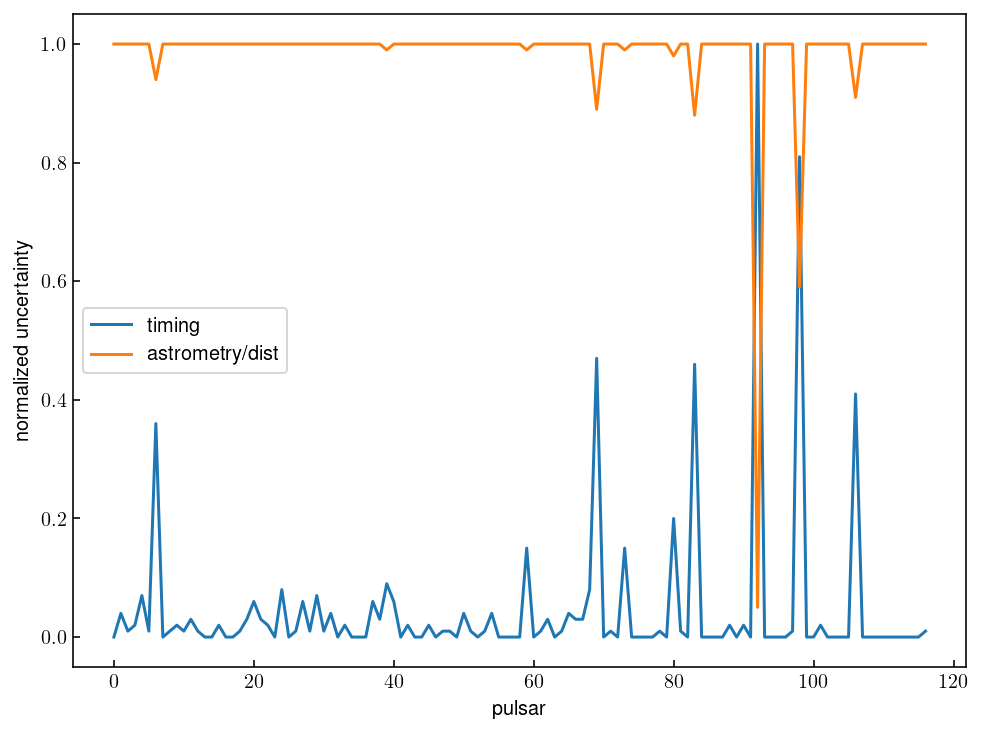

In [7]:
fig, ax = plt.subplots(figsize=(8,6))

plt.plot(sy_p_normalized, label="timing")
plt.plot(sy_dist_normalized, label="astrometry/dist")
plt.legend()
plt.ylabel("normalized uncertainty")
plt.xlabel("pulsar")

plt.savefig('spin_uncertainties.png', dpi=300, bbox_inches='tight')

***
## Bayesian mixture model
Our likelihood function $\mathcal{L}\equiv\text{Pr}\left(\left\{a_i\right\}|a_0,\lambda,P_{\textrm{bg}},\mu_{\textrm{bg}},V_{\textrm{bg}}\right)$ is given by the expression
\begin{equation}
\mathcal{L}\propto\prod_{i}\left[\left(1-P_{\textrm{bg}}\right)\varphi_{\mathcal{N}}\left(\frac{a_i-a_0 f_i}{\sqrt{V_i}}\right)\ast\varphi_{\mathcal{R}}\left(\frac{a_i}{\lambda}\right)+P_{\textrm{bg}}\varphi_{\mathcal{N}}\left(\frac {a_i-\mu_{\textrm{bg}}}{\sqrt{\sigma^2_{ai}+V_{\textrm{bg}}}}\right)\right],
\end{equation}

where the weight for each observation in the first term is then related to the variance $V_i=\sigma^2_{ai}+a_{0}^{2}\sigma^2_{fi}-2a_{0}\sigma_{fai}$. 

The function $\varphi_{\mathcal{N}}\left(x\right)=\exp\left(-x^2/2\right)/\sqrt{2\pi}$ is the standard normal 
distribution. 

Similarly, $\varphi_{\mathcal{R}}\left(x\right)=x\exp\left(-x^2/2\right)$ is the standard Rayleigh distribution. 

Finally, the symbol $\ast$ denotes a convolution.

We choose uninformative priors on our parameters: $a_0\sim\mathcal{U}\left(-20,20\right)$, $\lambda\sim\mathcal{U}\left(0,10\right)$, $P_{\textrm{bg}}\sim\mathcal{U}\left(0,1\right)$, $\mu_{\textrm{bg}}\sim\mathcal{U}\left(-500,500\right)$ and $\textrm{ln} V_{\textrm{bg}}\sim\mathcal{U}\left(2,16\right)$. 

Multiplying this box prior with the likelihood defined earlier gives us the posterior distribution for our analysis. Parameter estimation is then a matter of sampling the posterior and finding the maximum. We do this with a Markov Chain Monte Carlo (MCMC) sampler.

In [8]:
def log_likelihood(theta, x, y, sx, sy, rxy):
    m, alpha, Pb, Yb, lVb = theta
    Vb = np.exp(lVb)
    res = y - m*x
    sig = np.sqrt(sy**2 + m**2 * sx**2 - 2*m*rxy*sx*sy)
    squad = np.sqrt(sig**2+alpha**2)
    term1 = norm.pdf(res,0,sig)*(sig/squad)**2
    term2 = norm.pdf(res,0,squad)*res/2*alpha/squad**2*np.sqrt(2*np.pi)
    modif = 1+erf(alpha/sig*res/(np.sqrt(2*squad**2)))
    fg = (1-Pb) * np.abs(term1 + term2 * modif)
    bg = Pb * norm.pdf(y, Yb, np.sqrt(sy**2 + Vb))
    
    return np.sum(np.log(fg+bg))

def log_prior(theta):
    m, alpha, Pb, Yb, lVb = theta
    if -20.0 < m < 20.0 and 0.0 < alpha < 10.0 and 0.0 < Pb < 1.0 and -500.0 < Yb < 500.0 and 2.0 < lVb < 16.0:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, sx, sy, rxy):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, sx, sy, rxy)

initial = np.array([2, 6, 0.1, 6, 9])
np.random.seed(1)
pos = initial + 1e-4 * np.random.randn(32, np.size(initial))
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, sx, sy, rxy))
sampler.run_mcmc(pos, 100000, progress=True);

100%|██████████| 100000/100000 [21:12<00:00, 78.57it/s]


## Display walker trajectories and compute autocorrelation time

<IPython.core.display.Math object>

<IPython.core.display.Math object>

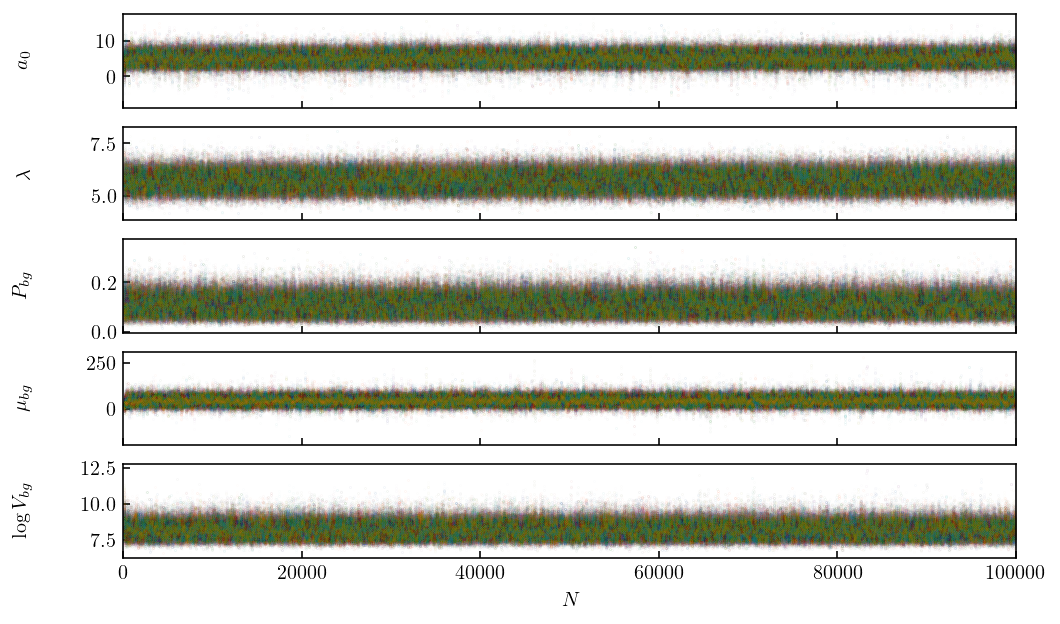

In [9]:
fig, axes = plt.subplots(ndim, figsize=(8, 5), sharex=True)
samples = sampler.get_chain()
labels = ["$a_0$","$\\lambda$","$P_{bg}$","$\\mu_{bg}$","$\log{V_{bg}}$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], ".", alpha=.1, markersize=.1)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("$N$");

tau = sampler.get_autocorr_time()

flat_samples = sampler.get_chain(discard=int(np.max(tau)*4), thin=int(np.max(tau)), flat=True)

label = "\\tau_{max}"
txt = "\mathrm{{{1}}} = {0:.0f}"
txt = txt.format(np.max(tau), label)
display(Math(txt))
label = "\mathcal{N}_{eff}"
txt = "\mathrm{{{1}}} = {0:.0f}"
txt = txt.format(np.size(flat_samples), label)
display(Math(txt))

## Make corner plot to visualize posterior samples

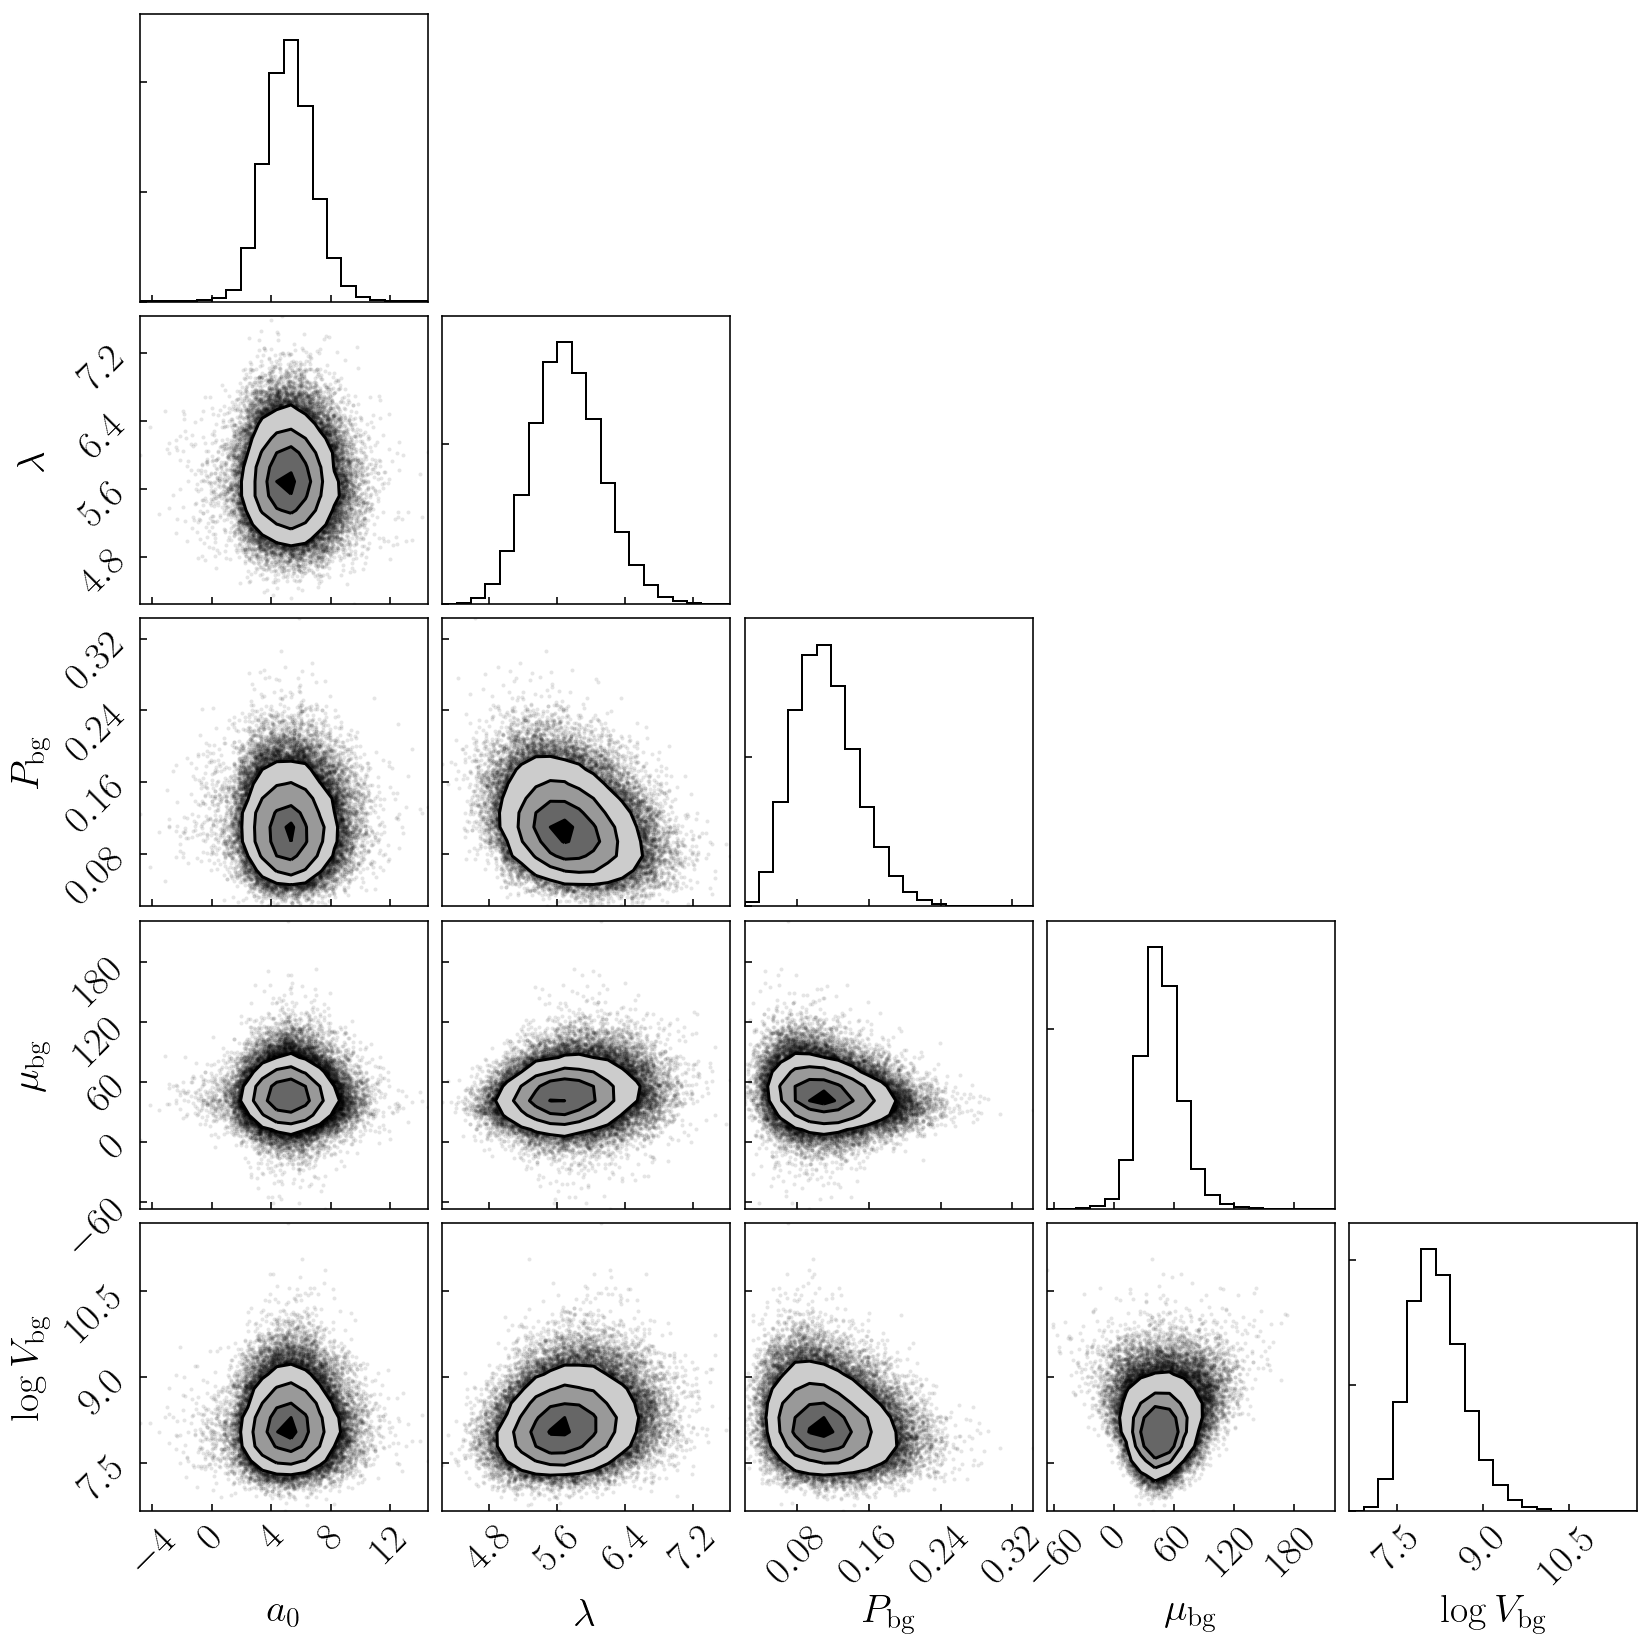

In [10]:
rcParams["font.size"] = 20
labels = ["$a_0$","$\\lambda$","$P_{\\mathrm{bg}}$","$\\mu_{\\mathrm{bg}}$","$\log{V_{\\mathrm{bg}}}$"]
fig = corner.corner(flat_samples, labels=labels, fill_contours=True)

# Save plot as pdf
plt.savefig('SMfig1.pdf', dpi=300, bbox_inches='tight')

## Plot results

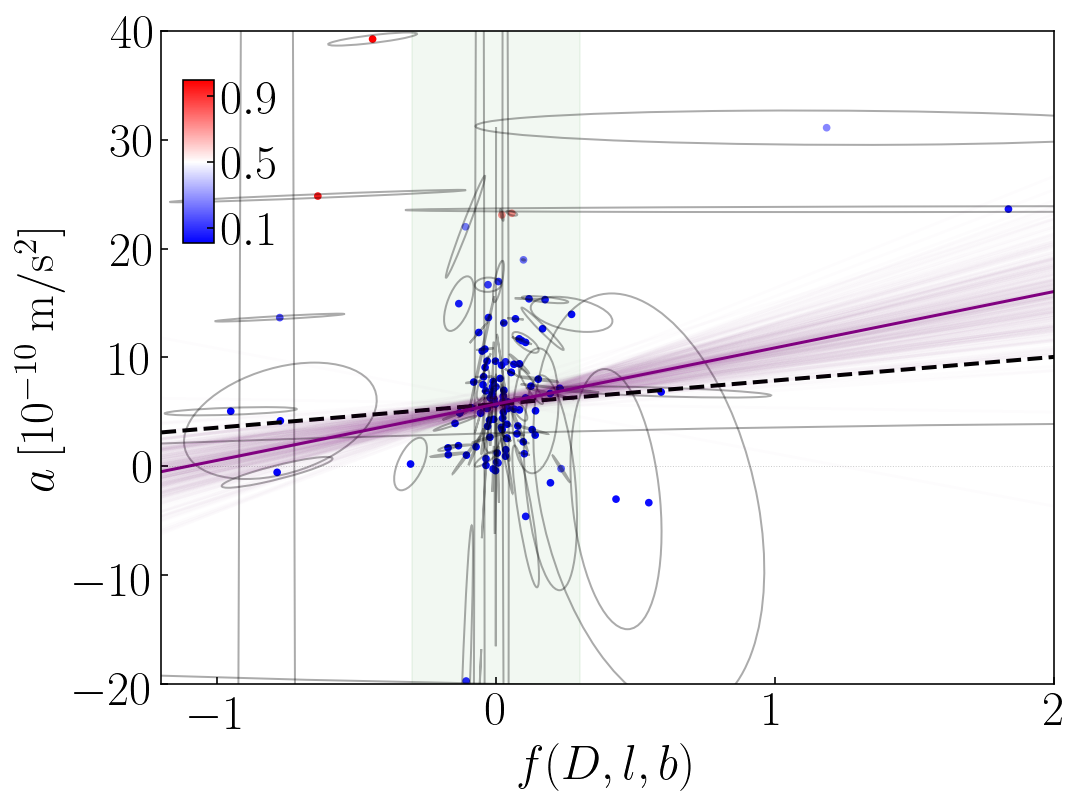

In [11]:
rcParams["font.size"] = 24
fig, ax = plt.subplots(figsize=(8,6))
xmax = 2.0
xmin = -1.2
ymin = -20
ymax = 40
mfit = np.percentile(flat_samples[:, 0], 50)
alphafit = np.percentile(flat_samples[:, 1], 50)
Pbfit = np.percentile(flat_samples[:, 2], 50)
Ybfit = np.percentile(flat_samples[:, 3], 50)
lVbfit = np.percentile(flat_samples[:, 4], 50)
parfit=[mfit, alphafit, Pbfit, Ybfit, lVbfit]
x0 = np.linspace(xmin,xmax,2)
bfit = alphafit
yfit = mfit*x0 + bfit
inds = np.random.randint(len(flat_samples), size=300)

# ADD |f|<0.3 region
plt.fill([-0.3,0.3,0.3,-0.3],[ymin,ymin,ymax,ymax],color='green',alpha=0.05);
plt.plot(x0,2.17*x0+bfit,'k--',lw=2)
for ind in inds:
    sample = flat_samples[ind]
    msample = sample[0]
    bsample = sample[1]
    plt.plot(x0, msample*x0 + bsample, 'purple', alpha=0.01)
plt.plot(x0,yfit,color='purple')
plt.plot(x0,[0, 0],'k:',alpha=0.2,lw=0.5)
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.xlabel('$f(D,l,b)$')
plt.ylabel('$a\:[10^{-10}\: \mathrm{m}/\mathrm{s}^2]$')
ellipses = []
npoints = np.size(x)
for ii in range(npoints):
    ycovar = np.zeros((2,2))
    ycovar[0,0] = sx[ii]**2.
    ycovar[1,1] = sy[ii]**2.
    ycovar[0,1] = rxy[ii]*np.sqrt(ycovar[0,0]*ycovar[1,1])
    ycovar[1,0] = ycovar[0,1]
    eigs = linalg.eig(ycovar)
    angle = np.arctan(-eigs[1][0,1].real/eigs[1][1,1].real)/np.pi*180.
    thisellipse = Ellipse(np.array([x[ii],y[ii]]),2*np.sqrt(eigs[0][0].real),
                        2*np.sqrt(eigs[0][1].real),angle)
    ellipses.append(thisellipse)

# COMPUTE OULIER SCORES
def label(theta, x, y, sx, sy, rxy):
    m, alpha, Pb, Yb, lVb = theta
    Vb = np.exp(lVb)
    res = y - m*x
    sig = np.sqrt(sy**2 + m**2 * sx**2 - 2*m*rxy*sx*sy)
    squad = np.sqrt(sig**2+alpha**2)
    term1 = norm.pdf(res,0,sig)*(sig/squad)**2
    term2 = norm.pdf(res,0,squad)*res/2*alpha/squad**2*np.sqrt(2*np.pi)
    modif = 1+erf(alpha/sig*res/(np.sqrt(2*squad**2)))
    fg = (1-Pb) * np.abs(term1 + term2 * modif)
    bg = Pb * norm.pdf(y, Yb, np.sqrt(sy**2 + Vb))
    return bg/(bg+fg)
nsamples = np.shape(flat_samples)[0]
out = np.zeros(shape=(nsamples,npoints))
for j in range(nsamples):
    out[j,:] = label(flat_samples[j,:],x,y,sx,sy,rxy)
Pbad = np.sum(out,axis=0)/nsamples

# ADD DATA POINTS
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.scatter(x, y, c=Pbad, cmap='bwr',s=8, marker='o',alpha=1)

# ADD ELLIPSES
ax = plt.gca()
for e in ellipses:
    ax.add_artist(e)
    e.set_facecolor('None')
    e.set_edgecolor('k')
    e.set_alpha(0.33)

# VISUALIZE EFFECTIVE Y-ERRORS
# yerr = np.sqrt(sy**2 + mfit**2 * sx**2 - 2*mfit*rxy*sx*sy)
# plt.errorbar(x, y, yerr, fmt='.b', capsize=2, elinewidth=0.1, markeredgewidth=0.1, markersize=0.1)

#ADD COLORBAR
axins = inset_axes(ax,
                   width='3.5%',
                   height='25%',
                   loc='upper left',
                   bbox_to_anchor=(-0.03, -0.001, 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=1)
plt.colorbar(cax=axins,orientation='vertical',ticks=[0.1,0.5,0.9]);

# Save plot as pdf
plt.savefig('fig2_1.pdf', dpi=300, bbox_inches='tight')

## Get parameter estimates and uncertainties

In [12]:
labels = ["\mathcal{a}_0","\\lambda","\mathcal{P}_{bg}","\mathcal{\\mu}_{bg}","\log\mathcal{V}_{bg}"]

mcmc = np.zeros(3)
for i in range(np.size(labels)):
    mcmc[0] = np.percentile(flat_samples[:, i], 16)
    mcmc[1] = np.percentile(flat_samples[:, i], 50)
    mcmc[2] = np.percentile(flat_samples[:, i], 84)
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.2f}_{{-{1:.2f}}}^{{{2:.2f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Show braking distribution

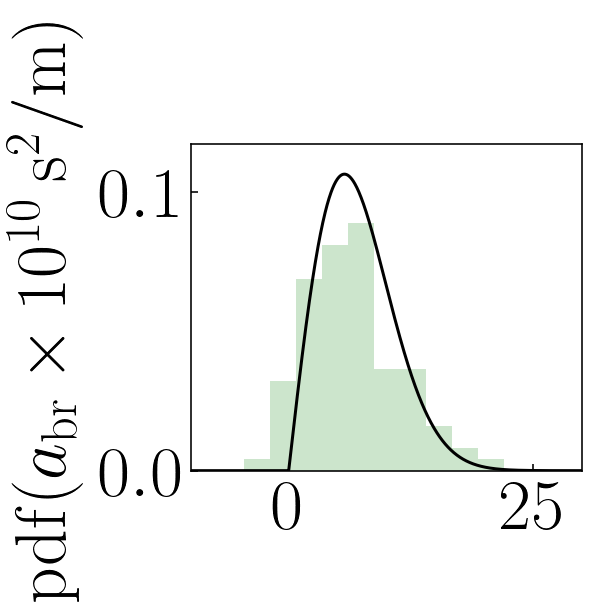

In [13]:
rcParams["font.size"] = 36
plt.figure(figsize=(3.5, 3))
amax = 30
amin = -10
pmin = 0

rem = Pbad < 0.5
yrem = y[rem]
xrem = x[rem]
filt1 = np.abs(xrem) < .3
filt2 = yrem > -10
filt3 = yrem < 40
filt = np.bitwise_and(np.bitwise_and(filt1,filt2),filt3)
yremfilt = yrem[filt]

a = np.linspace(amin,amax,1000)
p = rayleigh.pdf(a, 0, alphafit)

plt.hist(yremfilt,density=True,histtype='stepfilled',color='green',alpha=0.2);
pmax = np.max(p)*1.1
plt.plot(a,p,'k')
plt.xlim(amin,amax)
plt.ylim(pmin,pmax)
plt.ylabel("$\mathrm{pdf}(a_{\mathrm{br}} \\times 10^{10}\: \mathrm{s}^2/\mathrm{m})$");
# plt.title("$\mathrm{pdf}(a_{\mathrm{br}} \\times 10^{10}\: \mathrm{s}^2/\mathrm{m})$")
# plt.xlabel("$a_{\mathrm{br}}\:(10^{-10}\: \mathrm{m}/\mathrm{s}^2)$");

# Save plot as pdf
plt.savefig('fig2_2.pdf', dpi=300, bbox_inches='tight')

## Export data for Supplemental Material (outlier scores & uncertainity contributions)

In [14]:
sy_p_normalized = np.round(sy_p_normalized,2)
sy_dist_normalized = np.round(sy_dist_normalized,2)
sy = np.round(sy,2)

# Add outlier scores to the dataframe
data_OL = data
data_OL.insert(0,'outlier_score',Pbad)
data_OL.insert(0,'Timing_var',sy_p_normalized)
data_OL.insert(0,'Dist_var',sy_dist_normalized)
data_OL.insert(0,'total_var',sy)
data_OL = data_OL.sort_values(by='outlier_score', ascending=False)

In [21]:
# latex output

col1 = data_OL["NAME"][0:58].tolist()
col2 = data_OL["outlier_score"][0:58].tolist()
col2 = [round(x,3) for x in col2]
col22 = data_OL["Timing_var"][0:58].tolist()
col23 = data_OL["Dist_var"][0:58].tolist()
col24 = data_OL["total_var"][0:58].tolist()
col3 = data_OL["NAME"][58:116].tolist()
col4 = data_OL["outlier_score"][58:116].tolist()
col4 = [round(x,3) for x in col4]
col42 = data_OL["Timing_var"][58:116].tolist()
col43 = data_OL["Dist_var"][58:116].tolist()
col44 = data_OL["total_var"][58:116].tolist()
df = pd.DataFrame(col1,columns =['Pulsar name']);
df.insert(1,'Outlier score',col2)
df.insert(2,'T',col22)
df.insert(3,'D',col23)
df.insert(4,'tot',col24)
df.insert(5,'Pulsar name 1',col3)
df.insert(6,'Outlier score 1',col4)
df.insert(7,'T1',col42)
df.insert(8,'D1',col43)
df.insert(9,'tot1',col44)
#df.insert(8,'Pulsar name 2',col5)
#df.insert(9,'Outlier score 2',col6)
#df.insert(10,'T2',col62)
#df.insert(11,'D2',col63)
print(df.to_latex(index=False))

\begin{tabular}{lrrrrlrrrr}
\toprule
Pulsar name &  Outlier score &     T &     D &      tot & Pulsar name 1 &  Outlier score 1 &    T1 &    D1 &  tot1 \\
\midrule
 J1811-2405 &          1.000 &  0.00 &  1.00 &     0.27 &    J1804-2717 &            0.011 &  0.01 &  1.00 &  1.70 \\
 J1905+0400 &          1.000 &  0.46 &  0.88 &     0.00 &    J0824+0028 &            0.011 &  0.01 &  1.00 &  5.35 \\
 J0636+5129 &          1.000 &  0.00 &  1.00 &     0.55 &    J1903-7051 &            0.011 &  0.00 &  1.00 &  0.12 \\
 J0610-2100 &          1.000 &  0.01 &  1.00 &     1.07 &    J1923+2515 &            0.010 &  0.00 &  1.00 &  0.71 \\
 J0437-4715 &          1.000 &  0.01 &  1.00 &     0.61 &    J0711-6830 &            0.010 &  0.02 &  1.00 &  4.79 \\
 J1600-3053 &          1.000 &  0.02 &  1.00 &     0.60 &    J1903+0327 &            0.010 &  0.01 &  1.00 &  0.09 \\
 J1843-1113 &          1.000 &  0.00 &  1.00 &     4.17 &    J1955+2527 &            0.010 &  0.00 &  1.00 &  2.88 \\
 J1640+222